In [1]:
%%html
<style type='text/css'>
.CodeMirror{
    font-family: Inconsolata;
    font-size: 13px;
}

div.output_area pre {
    font-family: Inconsolata;
    font-size: 13px;
}

div.text_cell_render {
    font-family: Inconsolata;
    font-size: 13px;
}
</style>

Be inspired by this important notebook: [Converting a Tabular Dataset to a Temporal Graph Dataset for GNNs](https://colab.research.google.com/drive/1_eR7DXBF3V4EwH946dDPOxeclDBeKNMD?usp=sharing#scrollTo=MwVpsPRU-0ht)

In [2]:
import pandas as pd
import os
import torch
import numpy as np

import matplotlib

from tqdm.notebook import tqdm, tqdm_notebook
from datetime import datetime, timedelta

# path_dataset = r"D:\Datasets\mimic\mimic-iii-clinical-database-1.4"
path_dataset = r"/data/data2/041/datasets/mimic-iii-clinical-database-1.4"
list_csvgz = [f for f in os.listdir(path_dataset) if f[-6:]=="csv.gz"]
list_csvgz

['DRGCODES.csv.gz',
 'LABEVENTS.csv.gz',
 'PATIENTS.csv.gz',
 'D_ITEMS.csv.gz',
 'DIAGNOSES_ICD.csv.gz',
 'CAREGIVERS.csv.gz',
 'SERVICES.csv.gz',
 'CPTEVENTS.csv.gz',
 'PRESCRIPTIONS_NCV_SOLVED.csv.gz',
 'PRESCRIPTIONS_PREPROCESSED.csv.gz',
 'OUTPUTEVENTS.csv.gz',
 'D_LABITEMS.csv.gz',
 'D_ICD_DIAGNOSES.csv.gz',
 'LABEVENTS_NEW_remove_duplicate_edges.csv.gz',
 'CALLOUT.csv.gz',
 'PRESCRIPTIONS_TIMESTEP_SOLVED.csv.gz',
 'ADMISSIONS.csv.gz',
 'D_CPT.csv.gz',
 'INPUTEVENTS_MV.csv.gz',
 'D_LABITEMS_NEW.csv.gz',
 'PROCEDUREEVENTS_MV.csv.gz',
 'ADMISSIONS_NEW.csv.gz',
 'PRESCRIPTIONS.csv.gz',
 'NOTEEVENTS.csv.gz',
 'DATETIMEEVENTS.csv.gz',
 'MICROBIOLOGYEVENTS.csv.gz',
 'ICUSTAYS.csv.gz',
 'D_ICD_PROCEDURES.csv.gz',
 'PRESCRIPTIONS_DURATION_SOLVED.csv.gz',
 'LABEVENTS_NEW.csv.gz',
 'CHARTEVENTS.csv.gz',
 'TRANSFERS.csv.gz',
 'PROCEDURES_ICD.csv.gz',
 'LABEVENTS_PREPROCESSED.csv.gz',
 'INPUTEVENTS_CV.csv.gz']

In [4]:
[f for f in list_csvgz if f[-10:-7]=='NEW']

['D_LABITEMS_NEW.csv.gz', 'ADMISSIONS_NEW.csv.gz', 'LABEVENTS_NEW.csv.gz']

---

# ADMISSIONS

In [4]:
df_admissions = pd.read_csv(os.path.join(path_dataset, "ADMISSIONS.csv.gz"))

# Convert columns to datetime
df_admissions["ADMITTIME"] = pd.to_datetime(df_admissions["ADMITTIME"], format="%Y-%m-%d %H:%M:%S")
df_admissions["DISCHTIME"] = pd.to_datetime(df_admissions["DISCHTIME"], format="%Y-%m-%d %H:%M:%S")

df_admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                58976 non-null  int64         
 1   SUBJECT_ID            58976 non-null  int64         
 2   HADM_ID               58976 non-null  int64         
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   object        
 6   ADMISSION_TYPE        58976 non-null  object        
 7   ADMISSION_LOCATION    58976 non-null  object        
 8   DISCHARGE_LOCATION    58976 non-null  object        
 9   INSURANCE             58976 non-null  object        
 10  LANGUAGE              33644 non-null  object        
 11  RELIGION              58518 non-null  object        
 12  MARITAL_STATUS        48848 non-null  object        
 13  ETHNICITY       

In [5]:
df_admissions.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


## Node features

following columns are str type, which need to be remapped:

- ADMISSION_TYPE
- ADMISSION_LOCATION
- DISCHARGE_LOCATION
- INSURANCE
- LANGUAGE
- RELIGION
- MARITAL_STATUS
- ETHNICITY

Note: 

- some columns need to fill na!
- Not all columns above will be used as node_feature, because some columns
  - will cause infomation-leak problem
  - are not availabel until this hadm_id discharge

In [6]:
list_str_type_columns = ['ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']

for c in list_str_type_columns:
    m = df_admissions[c].value_counts()
    m = pd.Series(index=m.index, data=range(1, len(m)+1))
    df_admissions[c] = df_admissions[c].map(m)

values_fillna = {}
for c in list_str_type_columns:
    values_fillna[c] = 0  # use 0 to fill na

df_admissions.fillna(value=values_fillna, inplace=True)
df_admissions.tail()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
58971,58594,98800,191113,2131-03-30 21:13:00,2131-04-02 15:02:00,NaN,1,3,1,2,1.0,2.0,2.0,1,2131-03-30 19:44:00,2131-03-30 22:41:00,TRAUMA,0,1
58972,58595,98802,101071,2151-03-05 20:00:00,2151-03-06 09:10:00,2151-03-06 09:10:00,1,3,5,1,1.0,1.0,3.0,1,2151-03-05 17:23:00,2151-03-05 21:06:00,SAH,1,1
58973,58596,98805,122631,2200-09-12 07:15:00,2200-09-20 12:08:00,NaN,3,2,2,2,1.0,2.0,1.0,1,NaN,NaN,RENAL CANCER/SDA,0,1
58974,58597,98813,170407,2128-11-11 02:29:00,2128-12-22 13:11:00,NaN,1,1,3,2,1.0,1.0,1.0,1,2128-11-10 23:48:00,2128-11-11 03:16:00,S/P FALL,0,0
58975,58598,98813,190264,2131-10-25 03:09:00,2131-10-26 17:44:00,NaN,1,3,1,2,1.0,1.0,1.0,1,2131-10-25 00:08:00,2131-10-25 04:35:00,INTRACRANIAL HEMORRHAGE,0,1


In [7]:
df_admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                58976 non-null  int64         
 1   SUBJECT_ID            58976 non-null  int64         
 2   HADM_ID               58976 non-null  int64         
 3   ADMITTIME             58976 non-null  datetime64[ns]
 4   DISCHTIME             58976 non-null  datetime64[ns]
 5   DEATHTIME             5854 non-null   object        
 6   ADMISSION_TYPE        58976 non-null  int64         
 7   ADMISSION_LOCATION    58976 non-null  int64         
 8   DISCHARGE_LOCATION    58976 non-null  int64         
 9   INSURANCE             58976 non-null  int64         
 10  LANGUAGE              58976 non-null  float64       
 11  RELIGION              58976 non-null  float64       
 12  MARITAL_STATUS        58976 non-null  float64       
 13  ETHNICITY       

In [13]:
df_admissions.to_csv(os.path.join(path_dataset, "ADMISSIONS_NEW.csv.gz"))

---

# D_LABITEMS

In [8]:
df_d_labitems = pd.read_csv(os.path.join(path_dataset, "D_LABITEMS.csv.gz"))
df_d_labitems.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ROW_ID      753 non-null    int64 
 1   ITEMID      753 non-null    int64 
 2   LABEL       753 non-null    object
 3   FLUID       753 non-null    object
 4   CATEGORY    753 non-null    object
 5   LOINC_CODE  585 non-null    object
dtypes: int64(2), object(4)
memory usage: 35.4+ KB


In [9]:
df_d_labitems.head()

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5
2,548,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology,30398-2
3,549,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology,26506-6
4,550,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology,NaN


## Node features

In [10]:
list_str_type_columns = ['FLUID', 'CATEGORY']

for c in list_str_type_columns:
    m = df_d_labitems[c].value_counts()
    m = pd.Series(index=m.index, data=range(1, len(m)+1))
    df_d_labitems[c] = df_d_labitems[c].map(m)

df_d_labitems.head()

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,546,51346,Blasts,7,1,26447-3
1,547,51347,Eosinophils,7,1,26451-5
2,548,51348,"Hematocrit, CSF",7,1,30398-2
3,549,51349,Hypersegmented Neutrophils,7,1,26506-6
4,550,51350,Immunophenotyping,7,1,NaN


In [11]:
df_d_labitems.to_csv(os.path.join(path_dataset, "D_LABITEMS_NEW.csv.gz"))

___

# LABEVENTS

In [12]:
df_labevents = pd.read_csv(os.path.join(path_dataset, "LABEVENTS.csv.gz"))
df_labevents.dropna(subset=['HADM_ID', 'ITEMID'], inplace=True)
df_labevents.sort_values(by=["HADM_ID", "ITEMID"], inplace=True)
df_labevents["CHARTTIME"] = pd.to_datetime(df_labevents["CHARTTIME"], format="%Y-%m-%d %H:%M:%S")  # Convert columns to datetime
df_labevents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22245034 entries, 22704987 to 19982158
Data columns (total 9 columns):
 #   Column      Dtype         
---  ------      -----         
 0   ROW_ID      int64         
 1   SUBJECT_ID  int64         
 2   HADM_ID     float64       
 3   ITEMID      int64         
 4   CHARTTIME   datetime64[ns]
 5   VALUE       object        
 6   VALUENUM    float64       
 7   VALUEUOM    object        
 8   FLAG        object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 1.7+ GB


In [13]:
df_labevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
22704987,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.9,mmol/L,NaN
22695648,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.0,IU/L,NaN
22695649,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.0,IU/L,NaN
22601483,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.0,mEq/L,NaN
22695650,22441063,58526,100001.0,50868,2117-09-11 08:22:00,30,30.0,mEq/L,abnormal


## Non-value type labitems

In [14]:
df_labevents[df_labevents.VALUENUM.isnull()]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
22704997,22441098,58526,100001.0,51519,2117-09-11 08:53:00,NONE,NaN,NaN,NaN
22714857,22441179,58526,100001.0,51519,2117-09-12 08:41:00,NONE,NaN,NaN,NaN
22734094,22441227,58526,100001.0,51519,2117-09-13 08:21:00,NONE,NaN,NaN,NaN
22744021,22441268,58526,100001.0,51519,2117-09-14 10:08:00,NONE,NaN,NaN,NaN
21366480,21885268,54610,100003.0,50800,2150-04-17 18:12:00,ART,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
16641530,16833748,27200,199998.0,51508,2119-02-18 19:49:00,Yellow,NaN,NaN,NaN
16610981,16833959,27200,199998.0,51516,2119-02-22 09:32:00,21-50,NaN,#/hpf,abnormal
16610982,16833960,27200,199998.0,51519,2119-02-22 09:32:00,NONE,NaN,NaN,NaN
19982108,19961377,40370,199999.0,51519,2136-04-04 22:45:00,NONE,NaN,NaN,NaN


In [15]:
grouped_by_itemid_value_type_only = df_labevents[df_labevents.VALUENUM.notnull()].groupby("ITEMID")
grouped_by_itemid_not_value_type = df_labevents[df_labevents.VALUENUM.isnull()].groupby("ITEMID")  # Filter out non-value type labitems

set_itemid_value_type = list(grouped_by_itemid_value_type_only.groups.keys())
set_itemid_not_value_type = list(grouped_by_itemid_not_value_type.groups.keys())

set_itemid_pure_value_type     = np.setdiff1d(set_itemid_value_type,     set_itemid_not_value_type)  # pure value type itemids
set_itemid_mixed_value_type    = np.setdiff1d(set_itemid_value_type,     set_itemid_pure_value_type)  # mix value type itemids
set_itemid_pure_non_value_type = np.setdiff1d(set_itemid_not_value_type, set_itemid_mixed_value_type)  # pure value type itemids

set_itemid_pure_non_value_type

array([50800, 50812, 50827, 50828, 50829, 50845, 50858, 50859, 50871,
       50872, 50873, 50874, 50875, 50876, 50879, 50880, 50886, 50887,
       50901, 50913, 50918, 50919, 50920, 50932, 50933, 50937, 50938,
       50939, 50940, 50941, 50942, 50943, 50944, 50948, 50955, 50959,
       50975, 50979, 50999, 51017, 51056, 51071, 51074, 51075, 51079,
       51085, 51086, 51089, 51090, 51091, 51092, 51096, 51103, 51134,
       51135, 51141, 51142, 51145, 51147, 51151, 51153, 51154, 51155,
       51156, 51157, 51158, 51159, 51161, 51167, 51171, 51172, 51173,
       51177, 51178, 51179, 51182, 51183, 51187, 51189, 51190, 51191,
       51192, 51193, 51195, 51197, 51198, 51201, 51207, 51211, 51213,
       51215, 51216, 51217, 51219, 51220, 51230, 51231, 51234, 51235,
       51236, 51238, 51239, 51242, 51243, 51246, 51247, 51252, 51258,
       51260, 51261, 51262, 51266, 51268, 51278, 51286, 51287, 51290,
       51291, 51292, 51293, 51294, 51295, 51296, 51303, 51304, 51305,
       51306, 51307,

### Pure non-value type itemid

Need to re-map by catagrory.

In [16]:
df_labevents[df_labevents.ITEMID == 51374]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
26603510,26254618,87259,100747.0,51374,2109-12-04 12:00:00,NEEDLE,NaN,NaN,NaN
21112893,20783712,46641,102672.0,51374,2164-08-27 13:44:00,NEEDLE,NaN,NaN,NaN
7442947,7380863,11838,102892.0,51374,2137-05-14 14:21:00,RHOMBOID,NaN,NaN,NaN
27380460,27091246,93838,102946.0,51374,2106-09-28 22:08:00,RHOMBOID,NaN,NaN,NaN
8482664,8367295,13457,103720.0,51374,2189-09-06 10:02:00,NEEDLE,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
23943842,24222015,71743,196558.0,51374,2107-07-09 14:37:00,NEEDLE,NaN,NaN,NaN
19269887,19246689,31516,197262.0,51374,2197-07-25 17:11:00,RHOMBOID,NaN,NaN,NaN
18612999,18804470,30601,197881.0,51374,2141-05-27 09:15:00,NEEDLE,NaN,NaN,NaN
18613004,18804476,30601,197881.0,51374,2141-05-27 11:14:00,NEEDLE,NaN,NaN,NaN


In [17]:
s = df_labevents[df_labevents.ITEMID == 51374].VALUE.value_counts()
m = pd.Series(index=s.index, data=range(1, len(s)+1))
m

NEEDLE      1
RHOMBOID    2
ROD         3
dtype: int64

In [18]:
for itemid in tqdm(set_itemid_pure_non_value_type):
    s = df_labevents[df_labevents.ITEMID == itemid].VALUE.value_counts()
    m = pd.Series(index=s.index, data=range(1, len(s)+1))
    df_labevents.loc[df_labevents.ITEMID == itemid, 'CATAGORY'] = df_labevents[df_labevents.ITEMID == itemid].VALUE.map(m)

df_labevents[df_labevents.ITEMID == 51374]

  0%|          | 0/230 [00:00<?, ?it/s]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY
26603510,26254618,87259,100747.0,51374,2109-12-04 12:00:00,NEEDLE,NaN,NaN,NaN,1.0
21112893,20783712,46641,102672.0,51374,2164-08-27 13:44:00,NEEDLE,NaN,NaN,NaN,1.0
7442947,7380863,11838,102892.0,51374,2137-05-14 14:21:00,RHOMBOID,NaN,NaN,NaN,2.0
27380460,27091246,93838,102946.0,51374,2106-09-28 22:08:00,RHOMBOID,NaN,NaN,NaN,2.0
8482664,8367295,13457,103720.0,51374,2189-09-06 10:02:00,NEEDLE,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...
23943842,24222015,71743,196558.0,51374,2107-07-09 14:37:00,NEEDLE,NaN,NaN,NaN,1.0
19269887,19246689,31516,197262.0,51374,2197-07-25 17:11:00,RHOMBOID,NaN,NaN,NaN,2.0
18612999,18804470,30601,197881.0,51374,2141-05-27 09:15:00,NEEDLE,NaN,NaN,NaN,1.0
18613004,18804476,30601,197881.0,51374,2141-05-27 11:14:00,NEEDLE,NaN,NaN,NaN,1.0


In [25]:
df_labevents.CATAGORY.isnull().sum()

0

In [26]:
# TODO: fillna in CATAGORY for pure-value type 
df_labevents.CATAGORY.fillna(0, inplace=True)
df_labevents.CATAGORY.isnull().sum()

0

### Mix value type itemid

May we just drop these columns?

In [27]:
mask = df_labevents[df_labevents.ITEMID == 51228].VALUENUM.isnull()
df_labevents[df_labevents.ITEMID == 51228].loc[mask, :]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY


In [22]:
mask = df_labevents[df_labevents.ITEMID == 51228].VALUENUM.notnull()
df_labevents[df_labevents.ITEMID == 51228].loc[mask, :]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY
13098871,13263101,21431,100264.0,51228,2139-09-06 10:00:00,0.32,0.32,U/mL,NaN,0.0
21401687,21365162,50939,102047.0,51228,2174-09-05 05:28:00,0.30,0.30,U/mL,NaN,0.0
21415651,21365123,50939,102047.0,51228,2174-09-04 23:36:00,0.22,0.22,U/mL,abnormal,0.0
24381223,23969963,69719,102624.0,51228,2105-04-13 21:50:00,0.19,0.19,U/mL,abnormal,0.0
7076385,7191420,11559,103284.0,51228,2189-10-23 14:26:00,0.21,0.21,U/mL,abnormal,0.0
...,...,...,...,...,...,...,...,...,...,...
9729595,9645153,15624,192513.0,51228,2176-08-18 05:51:00,0.12,0.12,U/mL,abnormal,0.0
9731952,9645196,15624,192513.0,51228,2176-08-20 04:05:00,0.27,0.27,U/mL,abnormal,0.0
11992218,12284647,19830,195077.0,51228,2168-12-14 21:10:00,0.49,0.49,U/mL,NaN,0.0
16658867,16704005,27024,198972.0,51228,2149-12-29 13:10:00,1.52,1.52,U/mL,abnormal,0.0


In [23]:
for itemid in tqdm(set_itemid_mixed_value_type):
    mask = df_labevents[df_labevents.ITEMID == itemid].VALUENUM.isnull()
    list_index = df_labevents[df_labevents.ITEMID == itemid].loc[mask, :].index
    df_labevents.drop(list_index, inplace=True)

df_labevents.info()

  0%|          | 0/255 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21445662 entries, 22704987 to 19982157
Data columns (total 10 columns):
 #   Column      Dtype         
---  ------      -----         
 0   ROW_ID      int64         
 1   SUBJECT_ID  int64         
 2   HADM_ID     float64       
 3   ITEMID      int64         
 4   CHARTTIME   datetime64[ns]
 5   VALUE       object        
 6   VALUENUM    float64       
 7   VALUEUOM    object        
 8   FLAG        object        
 9   CATAGORY    float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 1.8+ GB


## Z-score of each labitem(value type)

In [28]:
grouped_by_itemid_value_type_only = df_labevents[df_labevents.VALUENUM.notnull()].groupby("ITEMID")
grouped_by_itemid_not_value_type = df_labevents[df_labevents.VALUENUM.isnull()].groupby("ITEMID")  # Filter out non-value type labitems

In [29]:
ITEMID = 51073
grouped_by_itemid_value_type_only.get_group(ITEMID)

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY
3835125,3823559,6024,104644.0,51073,2124-12-31 14:15:00,1,1.0,Ratio,NaN,0.0
24628075,24494582,73867,104935.0,51073,2130-05-23 14:36:00,3.1,3.1,Ratio,NaN,0.0
2215197,2103236,3338,106528.0,51073,2157-08-25 10:15:00,1,1.0,Ratio,NaN,0.0
1020901,1073735,1704,108250.0,51073,2114-10-24 02:19:00,2,2.0,Ratio,NaN,0.0
14975575,15336975,24851,111571.0,51073,2199-01-25 03:27:00,1,1.0,Ratio,NaN,0.0
7198587,7161350,11476,112237.0,51073,2129-11-12 02:50:00,1,1.0,Ratio,NaN,0.0
17112582,17710212,28677,112372.0,51073,2123-01-11 12:12:00,4,4.0,Ratio,NaN,0.0
23252070,22944693,62204,114209.0,51073,2159-04-30 08:01:00,586.3,586.3,Ratio,NaN,0.0
23013879,22695704,60104,115146.0,51073,2141-06-07 12:58:00,4.0,4.0,Ratio,NaN,0.0
16062208,16045174,25941,116752.0,51073,2183-11-27 03:00:00,1,1.0,Ratio,NaN,0.0


Notice that some itemids have abnormal VALUENUMs even the `FLAG` specifies they are not abnormal!

In [30]:
def box_analysis(data: pd.Series):
    # via. [利用 Pandas 进行数据处理](https://juejin.cn/post/6859254388021133326#heading-0)
    qu = data.quantile(q=0.75)
    ql = data.quantile(q=0.25)
    
    iqr = qu - ql  
    up = qu + 1.5 * iqr
    low = ql - 1.5 * iqr
    
    mask1 = data < up
    mask2 = data > low
    mask = mask1 & mask2

    return mask

ITEMID = 51073
mask = box_analysis(grouped_by_itemid_value_type_only.get_group(ITEMID).VALUENUM)
grouped_by_itemid_value_type_only.get_group(ITEMID).loc[mask, :]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY
3835125,3823559,6024,104644.0,51073,2124-12-31 14:15:00,1,1.0,Ratio,NaN,0.0
24628075,24494582,73867,104935.0,51073,2130-05-23 14:36:00,3.1,3.1,Ratio,NaN,0.0
2215197,2103236,3338,106528.0,51073,2157-08-25 10:15:00,1,1.0,Ratio,NaN,0.0
1020901,1073735,1704,108250.0,51073,2114-10-24 02:19:00,2,2.0,Ratio,NaN,0.0
14975575,15336975,24851,111571.0,51073,2199-01-25 03:27:00,1,1.0,Ratio,NaN,0.0
7198587,7161350,11476,112237.0,51073,2129-11-12 02:50:00,1,1.0,Ratio,NaN,0.0
17112582,17710212,28677,112372.0,51073,2123-01-11 12:12:00,4,4.0,Ratio,NaN,0.0
23013879,22695704,60104,115146.0,51073,2141-06-07 12:58:00,4.0,4.0,Ratio,NaN,0.0
16062208,16045174,25941,116752.0,51073,2183-11-27 03:00:00,1,1.0,Ratio,NaN,0.0
19071094,18485568,30026,119429.0,51073,2170-01-22 03:46:00,1,1.0,Ratio,NaN,0.0


Error: 
*A value is trying to be set on a copy of a slice from a DataFrame.*

Solution: 
[returning-a-view-versus-a-copy](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy), 
[How to deal with SettingWithCopyWarning in Pandas](https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas)

In [31]:
def three_theta(data: pd.Series):
    assert len(data) > 1
    
    std = data.std()
    mean = data.mean()
    
    up_bound = mean + 3*std
    low_bound = mean - 3*std
    
    mask = (data > low_bound) & (data < up_bound)
    return mask

ITEMID = 51073
mask = three_theta(grouped_by_itemid_value_type_only.get_group(ITEMID).VALUENUM)
grouped_by_itemid_value_type_only.get_group(ITEMID).loc[mask, :]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY
3835125,3823559,6024,104644.0,51073,2124-12-31 14:15:00,1,1.0,Ratio,NaN,0.0
24628075,24494582,73867,104935.0,51073,2130-05-23 14:36:00,3.1,3.1,Ratio,NaN,0.0
2215197,2103236,3338,106528.0,51073,2157-08-25 10:15:00,1,1.0,Ratio,NaN,0.0
1020901,1073735,1704,108250.0,51073,2114-10-24 02:19:00,2,2.0,Ratio,NaN,0.0
14975575,15336975,24851,111571.0,51073,2199-01-25 03:27:00,1,1.0,Ratio,NaN,0.0
7198587,7161350,11476,112237.0,51073,2129-11-12 02:50:00,1,1.0,Ratio,NaN,0.0
17112582,17710212,28677,112372.0,51073,2123-01-11 12:12:00,4,4.0,Ratio,NaN,0.0
23013879,22695704,60104,115146.0,51073,2141-06-07 12:58:00,4.0,4.0,Ratio,NaN,0.0
16062208,16045174,25941,116752.0,51073,2183-11-27 03:00:00,1,1.0,Ratio,NaN,0.0
19071094,18485568,30026,119429.0,51073,2170-01-22 03:46:00,1,1.0,Ratio,NaN,0.0


In [32]:
df_d_labitems[df_d_labitems.ITEMID == 51073]

,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
399,273,51073,"Amylase/Creatinine Ratio, Urine",2,2,34235-2


In [33]:
def z_score_4_value_type_labitem(df_grp):
    dfx = df_grp.copy()
    dfx_normal = dfx[dfx.FLAG.isnull()]
    
    # mask = box_analysis(dfx_normal.VALUENUM)  # using box analysis filter out abnormal value whose FLAG != 'abnormal'
    if len(dfx_normal) > 1:
        mask = three_theta(dfx_normal.VALUENUM)
        dfx_normal_filted = dfx_normal.loc[mask, :]
        if len(dfx_normal_filted) > 1:
            mean = dfx_normal_filted.VALUENUM.mean()
            std = dfx_normal_filted.VALUENUM.std() + 1e-7
        elif len(dfx_normal_filted) == 1:
            mean = dfx_normal_filted.VALUENUM.mean()
            std = dfx_normal_filted.VALUENUM.std(ddof=0) + 1e-7
        else:  # meaning that the normal entries have same values 0
            mean = 0
            std = 0 + 1e-7
        dfx['VALUENUM_Z-SCORED'] = dfx['VALUENUM'].apply(lambda x: (x-mean) / std)
    elif len(dfx_normal) == 1:
        mean = dfx_normal.VALUENUM.mean()
        std = dfx_normal.VALUENUM.std(ddof=0) + 1e-7
        dfx['VALUENUM_Z-SCORED'] = dfx['VALUENUM'].apply(lambda x: (x-mean) / std)
    else:  # 0, meaning all enties' FLAG="abnormal"
        dfx['VALUENUM_Z-SCORED'] = 3  # 3 or -3? worth discussing, but here set to 3 for convenience.
        
    return dfx

df_itemid_value_type_only_zscore = grouped_by_itemid_value_type_only.apply(z_score_4_value_type_labitem)
df_itemid_value_type_only_zscore

ROW_ID  SUBJECT_ID   HADM_ID  ITEMID           CHARTTIME  \
ITEMID                                                                        
50801  26141237  26327543       87977  100011.0   50801 2177-08-29 10:24:00   
       23455214  23806483       68591  100016.0   50801 2188-05-24 11:02:00   
       20244013  21034820       48539  100035.0   50801 2115-02-24 17:55:00   
       20244025  21034832       48539  100035.0   50801 2115-02-24 19:32:00   
       6058202    6003929        9588  100041.0   50801 2140-12-08 12:39:00   
...                   ...         ...       ...     ...                 ...   
51529  18784303  18678549       30376  166341.0   51529 2171-02-03 13:07:00   
       21124705  20456043       44265  168014.0   51529 2121-03-29 03:02:00   
       12160621  12107378       19522  179349.0   51529 2143-02-22 07:40:00   
       24442186  23620183       67209  183672.0   51529 2190-03-08 14:40:00   
51532  10430111  10588526       17081  103931.0   51532 2138-08-13 00:30:00   

                VALUE  VALUENUM VALUEUOM      FLAG  CATAGORY  \
ITEMID                                                         
50801  26141237   307     307.0    mm Hg       NaN       0.0   
       23455214   328     328.0    mm Hg       NaN       0.0   
       20244013   505     505.0    mm Hg       NaN       0.0   
       20244025   570     570.0    mm Hg       NaN       0.0   
       6058202    242     242.0      NaN       NaN       0.0   
...               ...       ...      ...       ...       ...   
51529  18784303   117     117.0    mg/dL       NaN       0.0   
       21124705   131     131.0    mg/dL  abnormal       0.0   
       12160621   117     117.0    mg/dL       NaN       0.0   
       24442186   120     120.0    mg/dL       NaN       0.0   
51532  10430111    43      43.0        %  abnormal       0.0   

                 VALUENUM_Z-SCORED  
ITEMID                              
50801  26141237          -1.333235  
       23455214          -1.165103  
       20244013           0.252004  
       20244025           0.772410  
       6058202           -1.853641  
...                            ...  
51529  18784303          -0.670820  
       21124705           4.546671  
       12160621          -0.670820  
       24442186           0.447214  
51532  10430111           3.000000  

[20115314 rows x 11 columns]

In [34]:
df_itemid_value_type_only_zscore.describe()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,VALUENUM,CATAGORY,VALUENUM_Z-SCORED
count,2.011531e+07,2.011531e+07,2.011531e+07,2.011531e+07,2.011531e+07,20115314.0,2.011531e+07
mean,1.467197e+07,3.416994e+04,1.499758e+05,5.103400e+04,7.662884e+01,0.0,2.159119e+05
std,8.194561e+06,2.829283e+04,2.886158e+04,1.922057e+02,4.880162e+03,0.0,2.232945e+07
min,1.000000e+00,2.000000e+00,1.000010e+05,5.080100e+04,-4.140000e+02,0.0,-6.350000e+08
25%,7.506112e+06,1.199300e+04,1.251170e+05,5.086800e+04,4.400000e+00,0.0,-1.090906e+00
50%,1.509442e+07,2.447100e+04,1.498880e+05,5.097000e+04,1.900000e+01,0.0,1.509201e-02
75%,2.196730e+07,5.510600e+04,1.750350e+05,5.124800e+04,6.000000e+01,0.0,1.447618e+00
max,2.790765e+07,9.999900e+04,1.999990e+05,5.153200e+04,1.104000e+07,0.0,7.730000e+09


### `NaN` problem in original z-score

Need to handle the `NaN` problems, which is caused by:

- some labitems have only one entry, that makes the denominator of std (n-1) become 0 (divide by 0 error product `NaN`!)
- some labitems' normal values are very close to each other (such as ITEMID=51003), that causes the IQR filter out all normal values, resulting mean and std become `NaN`.

In [35]:
df_itemid_value_type_only_zscore[df_itemid_value_type_only_zscore["VALUENUM_Z-SCORED"].isnull()]

,,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED
ITEMID,,,,,,,,,,,,


In [36]:
df_itemid_value_type_only_zscore["VALUENUM_Z-SCORED"].isnull().sum()

0

In [37]:
ITEMID = 50861
df_itemid_value_type_only_zscore[df_itemid_value_type_only_zscore.ITEMID == ITEMID]

ROW_ID  SUBJECT_ID   HADM_ID  ITEMID           CHARTTIME  \
ITEMID                                                                        
50861  22695648  22441061       58526  100001.0   50861 2117-09-11 08:22:00   
       21347517  21885203       54610  100003.0   50861 2150-04-17 12:30:00   
       21366862  21885307       54610  100003.0   50861 2150-04-18 05:25:00   
       21366900  21885345       54610  100003.0   50861 2150-04-19 03:32:00   
       21376523  21885373       54610  100003.0   50861 2150-04-20 04:00:00   
...                   ...         ...       ...     ...                 ...   
       12622443  12042771       19412  199995.0   50861 2137-12-16 22:25:00   
       12622459  12042787       19412  199995.0   50861 2137-12-17 07:30:00   
       12622479  12042807       19412  199995.0   50861 2137-12-18 05:58:00   
       12627667  12042834       19412  199995.0   50861 2137-12-19 11:30:00   
       16641533  16833751       27200  199998.0   50861 2119-02-19 12:10:00   

                VALUE  VALUENUM VALUEUOM      FLAG  CATAGORY  \
ITEMID                                                         
50861  22695648    10      10.0     IU/L       NaN       0.0   
       21347517   126     126.0     IU/L  abnormal       0.0   
       21366862   114     114.0     IU/L  abnormal       0.0   
       21366900   116     116.0     IU/L  abnormal       0.0   
       21376523   109     109.0     IU/L  abnormal       0.0   
...               ...       ...      ...       ...       ...   
       12622443    26      26.0     IU/L       NaN       0.0   
       12622459    55      55.0     IU/L  abnormal       0.0   
       12622479    51      51.0     IU/L  abnormal       0.0   
       12627667    38      38.0     IU/L       NaN       0.0   
       16641533    27      27.0     IU/L       NaN       0.0   

                 VALUENUM_Z-SCORED  
ITEMID                              
50861  22695648          -1.200442  
       21347517          11.306288  
       21366862          10.012488  
       21366900          10.228122  
       21376523           9.473405  
...                            ...  
       12622443           0.524624  
       12622459           3.651306  
       12622479           3.220040  
       12627667           1.818424  
       16641533           0.632441  

[148454 rows x 11 columns]

In [38]:
df_labevents = df_labevents.merge(df_itemid_value_type_only_zscore[['ROW_ID', 'VALUENUM_Z-SCORED']], how='left', on='ROW_ID')
df_labevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED
0,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.9,mmol/L,NaN,0.0,1.514175
1,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.0,IU/L,NaN,0.0,-1.200442
2,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.0,IU/L,NaN,0.0,1.276112
3,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.0,mEq/L,NaN,0.0,0.225221
4,22441063,58526,100001.0,50868,2117-09-11 08:22:00,30,30.0,mEq/L,abnormal,0.0,5.877802


In [39]:
df_labevents[df_labevents.ITEMID == 51073]

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED
1012584,3823559,6024,104644.0,51073,2124-12-31 14:15:00,1,1.0,Ratio,NaN,0.0,-0.372150
1080662,24494582,73867,104935.0,51073,2130-05-23 14:36:00,3.1,3.1,Ratio,NaN,0.0,-0.335009
1399340,2103236,3338,106528.0,51073,2157-08-25 10:15:00,1,1.0,Ratio,NaN,0.0,-0.372150
1773193,1073735,1704,108250.0,51073,2114-10-24 02:19:00,2,2.0,Ratio,NaN,0.0,-0.354464
2501502,15336975,24851,111571.0,51073,2199-01-25 03:27:00,1,1.0,Ratio,NaN,0.0,-0.372150
2638491,7161350,11476,112237.0,51073,2129-11-12 02:50:00,1,1.0,Ratio,NaN,0.0,-0.372150
2661946,17710212,28677,112372.0,51073,2123-01-11 12:12:00,4,4.0,Ratio,NaN,0.0,-0.319091
3059949,22944693,62204,114209.0,51073,2159-04-30 08:01:00,586.3,586.3,Ratio,NaN,0.0,9.979775
3269260,22695704,60104,115146.0,51073,2141-06-07 12:58:00,4.0,4.0,Ratio,NaN,0.0,-0.319091
3603651,16045174,25941,116752.0,51073,2183-11-27 03:00:00,1,1.0,Ratio,NaN,0.0,-0.372150


In [40]:
# TODO: fillna in VALUENUM_Z-SCORED for non-value type
df_labevents['VALUENUM_Z-SCORED'].fillna(0, inplace=True)

In [41]:
df_labevents['VALUENUM_Z-SCORED'].isnull().sum()

0

## Choose interval

In [42]:
grouped_by_hadmid = df_labevents.groupby("HADM_ID")

In [43]:
HADM_ID = 100001
grouped_by_hadmid.get_group(HADM_ID).sort_values(by="CHARTTIME")

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED
199,22441082,58526,100001.0,51254,2117-09-11 08:22:00,1.1,1.10,%,abnormal,0.0,-1.600206
220,22441086,58526,100001.0,51279,2117-09-11 08:22:00,4.58,4.58,m/uL,NaN,0.0,-0.249702
45,22441067,58526,100001.0,50902,2117-09-11 08:22:00,101,101.00,mEq/L,NaN,0.0,-0.564238
213,22441085,58526,100001.0,51277,2117-09-11 08:22:00,13.6,13.60,%,NaN,0.0,-0.593931
204,22441084,58526,100001.0,51265,2117-09-11 08:22:00,466,466.00,K/uL,abnormal,0.0,2.793546
...,...,...,...,...,...,...,...,...,...,...,...
18,22441321,58526,100001.0,50882,2117-09-17 05:45:00,23,23.00,mEq/L,NaN,0.0,-1.112538
87,22441325,58526,100001.0,50960,2117-09-17 05:45:00,1.9,1.90,mg/dL,NaN,0.0,-0.529679
58,22441323,58526,100001.0,50912,2117-09-17 05:45:00,2.3,2.30,mg/dL,abnormal,0.0,6.786717
72,22441324,58526,100001.0,50931,2117-09-17 05:45:00,118,118.00,mg/dL,abnormal,0.0,2.999601


In [44]:
def count_labitems_during(df_grouped_by_hadmid: pd.DataFrame, interval_hour=24):
    df_grouped_by_hadmid = df_grouped_by_hadmid.sort_values(by="CHARTTIME")

    st = df_grouped_by_hadmid.CHARTTIME.iloc[0]  # st <- start time
    et = df_grouped_by_hadmid.CHARTTIME.iloc[-1]  # et <- end time
    st = datetime.strptime(f"{st.year}-{st.month}-{st.day} {st.hour//interval_hour*interval_hour:2}:00:00", "%Y-%m-%d %H:%M:%S")
    et = datetime.strptime(f"{et.year}-{et.month}-{et.day} {(((et.hour//interval_hour)+1)*interval_hour)-1:2}:59:59", "%Y-%m-%d %H:%M:%S")

    interval = timedelta(hours=interval_hour)
    list_count = []
    while st < et:
        list_count.append(
            df_grouped_by_hadmid[(st <= df_grouped_by_hadmid.CHARTTIME) & 
            (df_grouped_by_hadmid.CHARTTIME <= st + interval)].shape[0])
        st += interval

    return list_count

HADM_ID = 199765
count_labitems_during(grouped_by_hadmid.get_group(HADM_ID))

[39, 68, 38, 24, 30, 21, 12, 13, 0, 0, 0, 0, 20]

In [45]:
bucket_elements = []
for hadm_id, df_grouped_by_hadmid in tqdm(grouped_by_hadmid):
    list_count = count_labitems_during(df_grouped_by_hadmid)
    for idx, cnt in enumerate(list_count):
        bucket_elements.append(cnt) if idx == len(bucket_elements) else None
        bucket_elements[idx] += cnt

  0%|          | 0/58151 [00:00<?, ?it/s]

In [46]:
num_hadm = df_admissions.HADM_ID.unique().shape[0]
bucket_elements = [elm / num_hadm for elm in bucket_elements]

<AxesSubplot:title={'center':'Average number of laboratory items during hospitalization'}, xlabel='day'>

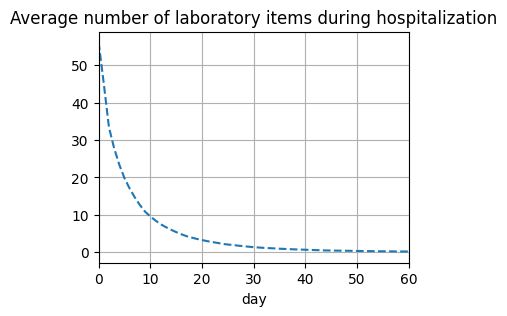

In [47]:
df_cnt_labitems_by_day_per_hadmid = pd.DataFrame(bucket_elements, columns=["cnt_labitems_by_day_per_hadmid"]).reset_index()
df_cnt_labitems_by_day_per_hadmid.cnt_labitems_by_day_per_hadmid.plot(
    kind='line', figsize=(4, 3), grid=True, linestyle='--', 
    title="Average number of laboratory items during hospitalization", 
    xlabel="day", xlim=(0, 60)
)

## Build timestep

In [48]:
def add_timestep_per_hadmid(df_grouped_by_hadmid: pd.DataFrame):
    interval_hour = 24  # chosen interval
    df_grouped_by_hadmid = df_grouped_by_hadmid.sort_values(by="CHARTTIME")

    st = df_grouped_by_hadmid.CHARTTIME.iloc[0]  # st <- start time
    et = df_grouped_by_hadmid.CHARTTIME.iloc[-1]  # et <- end time
    st = datetime.strptime(f"{st.year}-{st.month}-{st.day} {st.hour//interval_hour*interval_hour:2}:00:00", "%Y-%m-%d %H:%M:%S")
    et = datetime.strptime(f"{et.year}-{et.month}-{et.day} {(((et.hour//interval_hour)+1)*interval_hour)-1:2}:59:59", "%Y-%m-%d %H:%M:%S")

    interval = timedelta(hours=interval_hour)

    dfx = df_grouped_by_hadmid.copy()
    dfx.insert(len(dfx.columns), "TIMESTEP", np.NaN)
    
    timestep = 0
    while st < et:
        mask = (st <= dfx.CHARTTIME) & (dfx.CHARTTIME <= st + interval)
        if len(dfx.loc[mask]) > 0:
            dfx.loc[mask, 'TIMESTEP'] = timestep
            timestep += 1
        st += interval

    return dfx

HADM_ID = 100001
add_timestep_per_hadmid(grouped_by_hadmid.get_group(HADM_ID))

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
199,22441082,58526,100001.0,51254,2117-09-11 08:22:00,1.1,1.10,%,abnormal,0.0,-1.600206,0.0
220,22441086,58526,100001.0,51279,2117-09-11 08:22:00,4.58,4.58,m/uL,NaN,0.0,-0.249702,0.0
45,22441067,58526,100001.0,50902,2117-09-11 08:22:00,101,101.00,mEq/L,NaN,0.0,-0.564238,0.0
213,22441085,58526,100001.0,51277,2117-09-11 08:22:00,13.6,13.60,%,NaN,0.0,-0.593931,0.0
204,22441084,58526,100001.0,51265,2117-09-11 08:22:00,466,466.00,K/uL,abnormal,0.0,2.793546,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18,22441321,58526,100001.0,50882,2117-09-17 05:45:00,23,23.00,mEq/L,NaN,0.0,-1.112538,6.0
87,22441325,58526,100001.0,50960,2117-09-17 05:45:00,1.9,1.90,mg/dL,NaN,0.0,-0.529679,6.0
58,22441323,58526,100001.0,50912,2117-09-17 05:45:00,2.3,2.30,mg/dL,abnormal,0.0,6.786717,6.0
72,22441324,58526,100001.0,50931,2117-09-17 05:45:00,118,118.00,mg/dL,abnormal,0.0,2.999601,6.0


In [49]:
df_grouped_by_hadmid_timestep_added = grouped_by_hadmid.apply(add_timestep_per_hadmid)
df_grouped_by_hadmid_timestep_added

ROW_ID  SUBJECT_ID   HADM_ID  ITEMID           CHARTTIME  \
HADM_ID                                                                         
100001.0 199       22441082       58526  100001.0   51254 2117-09-11 08:22:00   
         220       22441086       58526  100001.0   51279 2117-09-11 08:22:00   
         45        22441067       58526  100001.0   50902 2117-09-11 08:22:00   
         213       22441085       58526  100001.0   51277 2117-09-11 08:22:00   
         204       22441084       58526  100001.0   51265 2117-09-11 08:22:00   
...                     ...         ...       ...     ...                 ...   
199999.0 21445598  19961560       40370  199999.0   51250 2136-04-10 01:28:00   
         21445487  19961548       40370  199999.0   50902 2136-04-10 01:28:00   
         21445590  19961559       40370  199999.0   51249 2136-04-10 01:28:00   
         21445545  19961555       40370  199999.0   51006 2136-04-10 01:28:00   
         21445624  19961562       40370  199999.0   51277 2136-04-10 01:28:00   

                  VALUE  VALUENUM VALUEUOM      FLAG  CATAGORY  \
HADM_ID                                                          
100001.0 199        1.1      1.10        %  abnormal       0.0   
         220       4.58      4.58     m/uL       NaN       0.0   
         45         101    101.00    mEq/L       NaN       0.0   
         213       13.6     13.60        %       NaN       0.0   
         204        466    466.00     K/uL  abnormal       0.0   
...                 ...       ...      ...       ...       ...   
199999.0 21445598    92     92.00       fL       NaN       0.0   
         21445487   102    102.00    mEq/L       NaN       0.0   
         21445590  33.2     33.20        %       NaN       0.0   
         21445545    16     16.00    mg/dL       NaN       0.0   
         21445624  14.3     14.30        %       NaN       0.0   

                   VALUENUM_Z-SCORED  TIMESTEP  
HADM_ID                                         
100001.0 199               -1.600206       0.0  
         220               -0.249702       0.0  
         45                -0.564238       0.0  
         213               -0.593931       0.0  
         204                2.793546       0.0  
...                              ...       ...  
199999.0 21445598           0.565825       6.0  
         21445487          -0.272444       6.0  
         21445590          -0.110958       6.0  
         21445545           0.603423       6.0  
         21445624           0.215884       6.0  

[21445662 rows x 12 columns]

In [50]:
HADM_ID = 199765
df_grouped_by_hadmid_timestep_added[df_grouped_by_hadmid_timestep_added.HADM_ID == HADM_ID]

ROW_ID  SUBJECT_ID   HADM_ID  ITEMID           CHARTTIME  \
HADM_ID                                                                       
199765.0 21389065  198768         313  199765.0   50908 2139-07-26 14:53:00   
         21389095  198774         313  199765.0   50960 2139-07-26 14:53:00   
         21389195  198788         313  199765.0   51265 2139-07-26 14:53:00   
         21389188  198787         313  199765.0   51250 2139-07-26 14:53:00   
         21389181  198786         313  199765.0   51249 2139-07-26 14:53:00   
...                   ...         ...       ...     ...                 ...   
         21389222  199044         313  199765.0   51279 2139-08-07 04:40:00   
         21389124  199035         313  199765.0   50983 2139-08-07 04:40:00   
         21389112  199034         313  199765.0   50971 2139-08-07 04:40:00   
         21389092  199032         313  199765.0   50960 2139-08-07 04:40:00   
         21389037  199027         313  199765.0   50882 2139-08-07 04:40:00   

                  VALUE  VALUENUM VALUEUOM      FLAG  CATAGORY  \
HADM_ID                                                          
199765.0 21389065   1.3      1.30        %       NaN       0.0   
         21389095   2.0      2.00    mg/dL       NaN       0.0   
         21389195   201    201.00     K/uL       NaN       0.0   
         21389188    89     89.00       fL       NaN       0.0   
         21389181  32.6     32.60        %       NaN       0.0   
...                 ...       ...      ...       ...       ...   
         21389222  3.91      3.91     m/uL  abnormal       0.0   
         21389124   142    142.00    mEq/L       NaN       0.0   
         21389112   4.1      4.10    mEq/L       NaN       0.0   
         21389092   2.0      2.00    mg/dL       NaN       0.0   
         21389037    27     27.00    mEq/L       NaN       0.0   

                   VALUENUM_Z-SCORED  TIMESTEP  
HADM_ID                                         
199765.0 21389065          -0.848225       0.0  
         21389095          -0.120601       0.0  
         21389195          -0.754770       0.0  
         21389188          -0.173540       0.0  
         21389181          -0.695424       0.0  
...                              ...       ...  
         21389222          -2.045744       8.0  
         21389124           0.975976       8.0  
         21389112           0.037039       8.0  
         21389092          -0.120601       8.0  
         21389037           0.377594       8.0  

[265 rows x 12 columns]

In [51]:
df_labevents = df_labevents.merge(df_grouped_by_hadmid_timestep_added[['ROW_ID', 'TIMESTEP']], how='left', on='ROW_ID', copy=False)
df_labevents = df_labevents[df_labevents.TIMESTEP.notnull()]  # above `merge` step will introduce `nan`
df_labevents.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
0,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.9,mmol/L,NaN,0.0,1.514175,0.0
1,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.0,IU/L,NaN,0.0,-1.200442,0.0
2,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.0,IU/L,NaN,0.0,1.276112,0.0
3,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.0,mEq/L,NaN,0.0,0.225221,6.0
4,22441063,58526,100001.0,50868,2117-09-11 08:22:00,30,30.0,mEq/L,abnormal,0.0,5.877802,0.0


<AxesSubplot:ylabel='Frequency'>

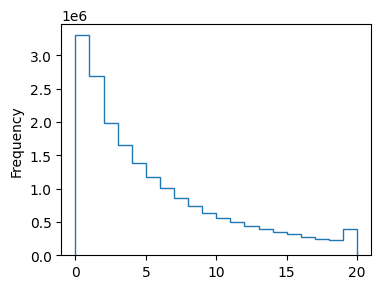

In [52]:
max_tiemstep = 20
df_labevents.TIMESTEP.plot(
    kind='hist', bins=20, range=(0, max_tiemstep), histtype="step", figsize=(4, 3))

In [54]:
df_labevents.describe()
df_labevents.to_csv(os.path.join(path_dataset, "LABEVENTS_NEW.csv.gz"))  # DONE

---

# New labevents

In [5]:
df_new_labevents = pd.read_csv(os.path.join(path_dataset, "LABEVENTS_NEW.csv.gz"))
df_new_labevents.head()

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
0,0,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.9,mmol/L,NaN,0.0,1.514175,0.0
1,1,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.0,IU/L,NaN,0.0,-1.200442,0.0
2,2,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.0,IU/L,NaN,0.0,1.276112,0.0
3,3,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.0,mEq/L,NaN,0.0,0.225221,6.0
4,4,22441063,58526,100001.0,50868,2117-09-11 08:22:00,30,30.0,mEq/L,abnormal,0.0,5.877802,0.0


## Merging repeat edges

- single admission
- single timestep
- multiple labitem
- multiple entries per labitem may exist!

In [6]:
gb_hadmid = df_new_labevents.groupby("HADM_ID")
gb_hadmid.get_group(100001)

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
0,0,22441088,58526,100001.0,50813,2117-09-11 08:32:00,1.9,1.900,mmol/L,NaN,0.0,1.514175,0.0
1,1,22441061,58526,100001.0,50861,2117-09-11 08:22:00,10,10.000,IU/L,NaN,0.0,-1.200442,0.0
2,2,22441062,58526,100001.0,50863,2117-09-11 08:22:00,105,105.000,IU/L,NaN,0.0,1.276112,0.0
3,3,22441320,58526,100001.0,50868,2117-09-17 05:45:00,14,14.000,mEq/L,NaN,0.0,0.225221,6.0
4,4,22441063,58526,100001.0,50868,2117-09-11 08:22:00,30,30.000,mEq/L,abnormal,0.0,5.877802,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,259,22441266,58526,100001.0,51498,2117-09-14 10:08:00,1.006,1.006,,NaN,0.0,-1.409149,3.0
260,260,22441097,58526,100001.0,51516,2117-09-11 08:53:00,2,2.000,#/hpf,NaN,0.0,0.389876,0.0
261,261,22441178,58526,100001.0,51516,2117-09-12 08:41:00,1,1.000,#/hpf,NaN,0.0,-0.247846,1.0
262,262,22441226,58526,100001.0,51516,2117-09-13 08:21:00,2,2.000,#/hpf,NaN,0.0,0.389876,2.0


In [7]:
df_curr_hadmid = gb_hadmid.get_group(100001)

max_timestep = df_curr_hadmid.TIMESTEP.max()

df_curr_hadmid_curr_timestep = df_curr_hadmid[df_curr_hadmid.TIMESTEP == 1]

sr_itemid_value_counts = df_curr_hadmid_curr_timestep.ITEMID.value_counts()
sr_itemid_repeat = sr_itemid_value_counts[sr_itemid_value_counts > 1]

df_curr_hadmid_curr_timestep[df_curr_hadmid_curr_timestep.ITEMID == sr_itemid_repeat.index[-1]]

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
206,206,22441168,58526,100001.0,51265,2117-09-12 03:36:00,407,407.0,K/uL,NaN,0.0,2.003544,1.0
207,207,22441216,58526,100001.0,51265,2117-09-12 23:15:00,378,378.0,K/uL,NaN,0.0,1.615237,1.0


In [8]:
perserve_entry_value = df_curr_hadmid_curr_timestep[df_curr_hadmid_curr_timestep.ITEMID == sr_itemid_repeat.index[-1]]["VALUENUM_Z-SCORED"].mean()
perserve_entry_value

1.8093904705541144

### 2 choices

- use mean value
- use last entry

After thinking, I decided to use last entry. Because it represents for the hadm's last situation at current timestep!

In [7]:
perserve_entry_rowid = df_curr_hadmid_curr_timestep[df_curr_hadmid_curr_timestep.ITEMID == sr_itemid_repeat.index[-1]].sort_values(by="CHARTTIME").ROW_ID.iloc[-1]
deprecate_entry_rowid = df_curr_hadmid_curr_timestep[df_curr_hadmid_curr_timestep.ITEMID == sr_itemid_repeat.index[-1]].sort_values(by="CHARTTIME").ROW_ID.iloc[0:-1]

# df_new_labevents.loc[df_new_labevents.ROW_ID == perserve_entry_rowid, "VALUENUM_Z-SCORED"] = perserve_entry_value
df_new_labevents[df_new_labevents.ROW_ID == perserve_entry_rowid]

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
207,207,22441216,58526,100001.0,51265,2117-09-12 23:15:00,378,378.0,K/uL,NaN,0.0,1.615237,1.0


In [8]:
deprecate_entry_rowid

206    22441168
Name: ROW_ID, dtype: int64

In [ ]:
drop_indexs = []
for hadm_id in tqdm(df_new_labevents.HADM_ID.unique()):
    df_curr_hadmid = df_new_labevents[df_new_labevents.HADM_ID == hadm_id]
    
    for timestep in range(int(df_curr_hadmid.TIMESTEP.max()) + 1):
        df_curr_hadmid_curr_timestep = df_curr_hadmid[df_curr_hadmid.TIMESTEP == timestep]
        
        sr_itemid_value_counts = df_curr_hadmid_curr_timestep.ITEMID.value_counts()
        sr_itemid_repeat = sr_itemid_value_counts[sr_itemid_value_counts > 1]
        
        for itemid_repeat in list(sr_itemid_repeat.index):
            deprecate_entry_rowid = df_curr_hadmid_curr_timestep[df_curr_hadmid_curr_timestep.ITEMID == itemid_repeat].sort_values(by="CHARTTIME").ROW_ID.iloc[0:-1]
            deprecate_entry_index = list(deprecate_entry_rowid.index)
            drop_indexs.extend(deprecate_entry_index)

    if len(drop_indexs) > 13333:
        df_new_labevents.drop(drop_indexs, inplace=True)
        drop_indexs = []

len(drop_indexs)

In [ ]:
df_new_labevents.drop(drop_indexs, inplace=True)
df_new_labevents.to_csv(os.path.join(path_dataset, "LABEVENTS_NEW_remove_duplicate_edges.csv.gz"))  # DONE

## post-check

In [3]:
df_new_labevents_remove_duplicate_edges = pd.read_csv(os.path.join(path_dataset, "LABEVENTS_PREPROCESSED.csv.gz"))
# df_new_labevents_remove_duplicate_edges = pd.read_csv(os.path.join(path_dataset, "LABEVENTS_NEW_remove_duplicate_edges.csv.gz"))
df_new_labevents_remove_duplicate_edges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15186986 entries, 0 to 15186985
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   ROW_ID             int64  
 2   SUBJECT_ID         int64  
 3   HADM_ID            float64
 4   ITEMID             int64  
 5   CHARTTIME          object 
 6   VALUE              object 
 7   VALUENUM           float64
 8   VALUEUOM           object 
 9   FLAG               object 
 10  CATAGORY           float64
 11  VALUENUM_Z-SCORED  float64
 12  TIMESTEP           float64
dtypes: float64(5), int64(4), object(4)
memory usage: 1.5+ GB


In [4]:
df_new_labevents_remove_duplicate_edges.describe()

,Unnamed: 0,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,VALUENUM,CATAGORY,VALUENUM_Z-SCORED,TIMESTEP
count,1.518699e+07,1.518699e+07,1.518699e+07,1.518699e+07,1.518699e+07,1.431841e+07,1.518699e+07,1.518699e+07,1.518699e+07
mean,1.072184e+07,1.463560e+07,3.399820e+04,1.499688e+05,5.106818e+04,8.038874e+01,2.621940e-01,2.406915e+05,9.343421e+00
std,6.188201e+06,8.182579e+06,2.820788e+04,2.885121e+04,1.955137e+02,5.267291e+03,8.098696e+00,2.302106e+07,1.416646e+01
min,0.000000e+00,2.000000e+01,2.000000e+00,1.000010e+05,5.080000e+04,-4.140000e+02,0.000000e+00,-6.350000e+08,0.000000e+00
25%,5.360600e+06,7.478083e+06,1.195200e+04,1.251080e+05,5.089300e+04,4.200000e+00,0.000000e+00,-9.667195e-01,1.000000e+00
50%,1.073555e+07,1.506148e+07,2.439600e+04,1.499180e+05,5.098300e+04,1.700000e+01,0.000000e+00,0.000000e+00,5.000000e+00
75%,1.606335e+07,2.190326e+07,5.473600e+04,1.749180e+05,5.125000e+04,5.800000e+01,0.000000e+00,1.285080e+00,1.200000e+01
max,2.144566e+07,2.790765e+07,9.999900e+04,1.999990e+05,5.153700e+04,1.104000e+07,1.353000e+03,7.730000e+09,2.950000e+02


### check repeated edges

In [5]:
gb_hadmid = df_new_labevents_remove_duplicate_edges.groupby("HADM_ID")
df_curr_hadmid = gb_hadmid.get_group(199998)

max_timestep = df_curr_hadmid.TIMESTEP.max()

df_curr_hadmid_curr_timestep = df_curr_hadmid[df_curr_hadmid.TIMESTEP == 0]

sr_itemid_value_counts = df_curr_hadmid_curr_timestep.ITEMID.value_counts()
sr_itemid_repeat = sr_itemid_value_counts[sr_itemid_value_counts > 1]
sr_itemid_repeat

Series([], Name: ITEMID, dtype: int64)

In [6]:
df_new_labevents_remove_duplicate_edges["VALUENUM_Z-SCORED"].isnull().values.any()

False

In [7]:
len(df_new_labevents_remove_duplicate_edges["VALUENUM_Z-SCORED"])

15186986

In [8]:
_gb_hadmid = df_new_labevents_remove_duplicate_edges.groupby("HADM_ID")

def repeatability_check(df_curr_hadmid: pd.DataFrame):
    for timestep in range(int(df_curr_hadmid.TIMESTEP.max()) + 1):
        df_curr_hadmid_curr_timestep = df_curr_hadmid[df_curr_hadmid.TIMESTEP == timestep]
        sr_itemid_value_counts = df_curr_hadmid_curr_timestep.ITEMID.value_counts()
        sr_itemid_repeat = sr_itemid_value_counts[sr_itemid_value_counts > 1]
        assert len(sr_itemid_repeat) == 0

for k, df in tqdm(_gb_hadmid):
    repeatability_check(df)

  0%|          | 0/58132 [00:00<?, ?it/s]

Pass! Good!